<a href="https://colab.research.google.com/github/pieter98/question_metadata/blob/main/QM_notebooks/QM02_zero_shot_approach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Zero-shot approach
This notebook contains all code for a zero-shot attempt at "exam question classification". 

Our research revolves around automatically determining the topic of an exam question based on the question instruction and possible answers (e.g. a multiple choice question contains a set of possible answers which can give useful insights into the topic).

#### **!! for GDPR reasons the data used in this notebook is limited to only a few anonymised data samples ¡¡**

**Problem:**

We have a vast amount of data however this data is either not labelled at all or labelled incorrectly.
As there is a severe lack of useful, labelled datapoints a zero-shot approach was suggested. This zero-shot approach can then be used for meaningful topic suggestions or create labelled data.

In [23]:
# utility library tqdm
from tqdm import tqdm

## 1. Hugging Face transformer pipeline
The transformers library of Hugging Face has a zero-shot-classification pipeline for NLP ([huggingface discussion](https://huggingface.co/)). Using this pipeline we can easily tryout zero-shot classifications.

### 1.1. Install necessary libraries
We'll start off by installing the transformers library.

In [1]:
!pip install transformers==4.19.0

     |████████████████████████████████| 4.2 MB 31.8 MB/s 
     |████████████████████████████████| 596 kB 81.1 MB/s 
     |████████████████████████████████| 6.6 MB 78.7 MB/s 
     |████████████████████████████████| 84 kB 4.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### 1.3. zero-shot pipeline examples
Let's quickly test the zero shot pipeline using some sample data.

#### 1.3.1. Import data
As we can't use the assessmentQ dataset directly in this notebook due to GDPR restrictions, so we provided a dummy dataset of (anonymised) exam questions which can be found [here](https://github.com/pieter98/question_metadata/blob/main/data/dataset_en.csv).

Let's start by importing the data.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("sample_data/dataset_en.csv")
print(df.head())
print(df)

                                         Instruction
0  Hoite Wigsma a Dutch musician has designed an ...
1  Mark the only correct answer Some stars explod...
2  Choose the only correct answer Choose the corr...
3  A 250 mL vessel contains 0374 g of a gaseous p...
4  Mark the only correct answer Which theory of e...
                                          Instruction
0   Hoite Wigsma a Dutch musician has designed an ...
1   Mark the only correct answer Some stars explod...
2   Choose the only correct answer Choose the corr...
3   A 250 mL vessel contains 0374 g of a gaseous p...
4   Mark the only correct answer Which theory of e...
5                      What is the capital of France?
6   Mark the only correct answer. Which equation s...
7   Mark the only correct answer for each row. In ...
8   The ICSH hormone is secreted by the In the tes...
9   Please mark the only correct answer. Which tri...
10  Watch the video How can you explain the functi...
11  Type the answer in the empty b

#### 1.3.2. Example predictions with pipeline
Let's do some sample predictions using the pipeline and some predefined labels ("Chemistry", "History", "Geography", "Physics", "Biology").
We start by creating the pipeline and creating a subjects array containing the possible labels.

**Note:** by default the pipeline uses the 'facebook/bart-large-mnli' model ([hugging face link](https://huggingface.co/facebook/bart-large-mnli))

In [6]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
subjects = ["Chemistry", "History", "Geography", "Physics", "Biology"]

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Using the created pipeline we can now classify a few of our data samples:

In [7]:
for i in range(10):
  classification = classifier(df["Instruction"][i], subjects)
  print("{}) {}".format(i, classification["sequence"]))
  for i in range(len(classification["labels"])):
    print("\t{}: {}".format(classification["labels"][i], classification["scores"][i]))
  print("")

0) Hoite Wigsma a Dutch musician has designed an organ that works on the waves of the seawater The tones are created because the undulating water forces air through the tubes With a sound sensor and an oscilloscope the tone of the organ is made visible What is the period of this vibration ?
	Geography: 0.28657853603363037
	Physics: 0.22335126996040344
	History: 0.18328404426574707
	Chemistry: 0.16544802486896515
	Biology: 0.14133816957473755

1) Mark the only correct answer Some stars explode These are supernovae Less than ten of them have been observed on Earth in the past 2000 years Suppose Sirius explodes today When will you see this?
	Physics: 0.3551057279109955
	History: 0.33199506998062134
	Chemistry: 0.11198030412197113
	Biology: 0.10627324134111404
	Geography: 0.09464572370052338

2) Choose the only correct answer Choose the correct century Prince Philippe became king of Belgium in 2014 This is the ____ century
	History: 0.653565526008606
	Geography: 0.12510249018669128
	Biolog

This small sample size of datapoints gives us promising results. We can see that for most questions the model gives a reasonable predictions, e.g.:

- the question "What is the capital of France?" has Geography as label with the highest probability
- question 6 has "Chemistry" as its highest probability which is a reasonable prediction.
- ...

If the label probabilities seem to be incorrect (not what was expected), we can also derrive the reason for the "incorrect" classifications. E.g. question 1 has "Geography" as its most probable label however when reading the question, we would classify the topic to be Physics (which is the second highest probability). The high probability for "Geography" could be related to the presence of words such as "seawater, period, ..." which can be linked to the topic.

Conclusion: even the faulty predictions make some kind of sense


### 1.4. Measuring the accuracy of zero-shot learning

How do we measure the accuracy for the zero-shot learning approach? Zero-shot learning, inherently, does not use labeled data. It has no training phase where the model is optimized using a loss function, a validation set, test set, ... . 

To have some semblance of the accuracy of zero-shot learning we can label our data, establish a ground truth, and compare the top prediciton(s) of the zero-shot learning model to the correct label.

**However** manually labeling the existing data is a very time consuming task. Therefor we will leverage some existing machine learning based toolboxes to make this process easier.

# 2. Using BERTopic to label a subset of our data

*BERTopic is a toolbox that we used to quickly label a substantial amount of our data. This part consists of a small demo of the toolbox used on a public dataset as an illustration of its functionalities.Our own dataset is not used for this part as google collab crashed multiple times when loading in the data. In the end remarks of this section we've provided a link to a csv file which contain the results of BERTopic used on our own dataset.*

**From the [BERTopic website](https://maartengr.github.io/BERTopic/index.html):**

BERTopic is a topic modeling technique that leverages 🤗 transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

BERTopic supports guided, (semi-) supervised, and dynamic topic modeling. It even supports visualizations similar to LDAvis!


**In short**: the BERTopic toolbox allows us to cluster documents together based on their keywords. If we assign topic labels to these clusters we can label data in bulk (as question with the same distinguishable keywords can be categorised under the same topic). 

Let's do a quick demo of BERTopic using the skleurn 20 newsgroups dataset:

## 2.1. Installing BERTopic

In [3]:
!pip install bertopic

In [8]:
!pip install sklearn

## 2.2. Importing BERTopic and the dummy data

Let's create our BERTopic model:

In [10]:
from bertopic import BERTopic

topic_model = BERTopic()

Let's import our data:

In [11]:
from sklearn.datasets import fetch_20newsgroups

docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

## 2.3. Generating topics

Based on the dataset we can generate BERTopic topics (groupings based on keywords):

In [12]:
topics, probs = topic_model.fit_transform(docs)

After fitting the model we can print topic info:

In [13]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,6391,-1_to_the_is_of
1,0,1836,0_game_team_games_he
2,1,612,1_key_clipper_chip_encryption
3,2,531,2_ites_cheek_yep_huh
4,3,486,3_israel_israeli_jews_arab
...,...,...,...
221,220,10,220_610_iivx_c610_centris
222,221,10,221_seizure_seizures_corn_sp
223,222,10,222_rape_female_statutes_underwear
224,223,10,223_religion_justifiable_war_history


**Note:** group -1 are all documents who could not be assigned to a cluster

## 2.4 BERTopic on our own data

An example of BERTopic run on our own data can be found [here](https://github.com/pieter98/question_metadata/blob/main/data/BERTopic_example_dutch.xlsx).

As stated before, BERTopic is used as a tool to make bulk labeling possible. We used it to group our data based on keywords and if the keywords were logically related to a topic, we would assign this topic to the whole group.

Example from the BERTopic results:

image.png

Group 7 can clearly be identified as being related to electricity/physics. Therefor we assign these labels to all questions clustered within this group.

...



# 3. Accuracy measures for zero-shot learning

We have a labeled subset of our data (obtained by using BERTopic or manual labelling). We can now start some accuracy/useability measures for our zero-shot classification.

Let's start by loading our labeled subset of data *(a small anonymised dataset is used in this notebook).*

In [19]:
import pandas as pd

df_labeled = pd.read_csv("sample_data/dataset_en_labeled.csv", delimiter=";")
df_labeled.head()

,Instruction,Label
0,Hoite Wigsma a Dutch musician has designed an ...,Physics
1,Mark the only correct answer Some stars explod...,Geography
2,Choose the only correct answer Choose the corr...,History
3,A 250 mL vessel contains 0374 g of a gaseous p...,Chemistry
4,Mark the only correct answer Which theory of e...,Biology


## 3.1.  Is the most probable label correct?

A simple measure is checking wether the label with the highest probability is the same as the one we personally assigned to the question. Let's create a zero-shot classification pipeline and count how many times it predictions are correct.

In [22]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")
subjects = ["Chemistry", "History", "Geography", "Physics", "Biology"]

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [25]:
correct_count = 0
for index, row in tqdm(df_labeled.iterrows()):
  classification = classifier(row["Instruction"], subjects)
  if classification["labels"][0] == row["Label"]:
    correct_count = correct_count + 1
correct_count

49it [03:18,  4.05s/it]


33

In [28]:
print("Overall accuracy is {}%".format(round(correct_count/df_labeled.shape[0]*100, 2)))

Overall accuracy is 67.35%


We get an accuracy of 67.35%, which isn't bad! However a connotation has to be made, the subjects array is limited to only 5 topics/subjects that occur in our labeled sub-dataset.

Let's see what happens when we increase the amount of possible topics/subjects. After all, secondary education isn't limited to "Chemistry", "History", "Geography", "Physics" and "Biology".

In [30]:
subjects = ["Chemistry", "History", "Geography", "Physics", "Biology", "Mathematics", "English", "Religion", "Physical Education", "German", "Dutch", "French", "Latin", "Greek"]

In [31]:
correct_count = 0
for index, row in tqdm(df_labeled.iterrows()):
  classification = classifier(row["Instruction"], subjects)
  if classification["labels"][0] == row["Label"]:
    correct_count = correct_count + 1
correct_count

49it [08:29, 10.40s/it]


15

In [32]:
print("Overall accuracy is {}%".format(round(correct_count/df_labeled.shape[0]*100, 2)))

Overall accuracy is 30.61%


When we increasing the amount of subjects from 5 to 14, the accuracy drops by approx. 37%.

## 3.2. Accuracy for top-n labels

What if we not limit ourselves to only one label but instead take the top-n labels of the prediction? Can we counteract the decrease in accuracy when there are more possible subjects if we take more top predictions into account?

Lets start by checking out the top-2 labels:


In [45]:
correct_count_1 = 0
correct_count_2 = 0
correct_count_3 = 0
correct_count_4 = 0
correct_count_5 = 0
for index, row in tqdm(df_labeled.iterrows()):
  classification = classifier(row["Instruction"], subjects)
  if row["Label"] == classification["labels"][0]:
    correct_count_1 = correct_count_1 + 1
  if row["Label"] in classification["labels"][0:2]:
    correct_count_2 = correct_count_2 + 1
  if row["Label"] in classification["labels"][0:3]:
    correct_count_3 = correct_count_3 + 1
  if row["Label"] in classification["labels"][0:4]:
    correct_count_4 = correct_count_4 + 1
  if row["Label"] in classification["labels"][0:5]:
    correct_count_5 = correct_count_5 + 1

49it [09:25, 11.55s/it]


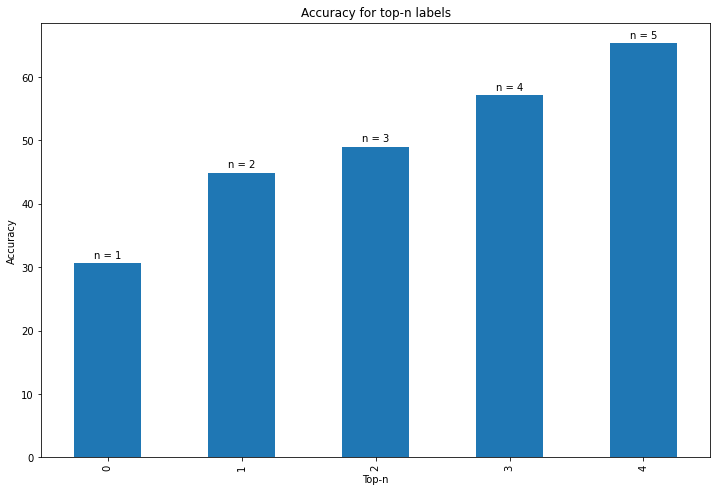

In [46]:
import matplotlib.pyplot as plt
scale = df_labeled.shape[0]
# Bring some raw data.
percentages = [correct_count_1/scale*100, correct_count_2/scale*100, correct_count_3/scale*100, correct_count_4/scale*100, correct_count_5/scale*100]
# In my original code I create a series and run on that,
# so for consistency I create a series from the list.
percentages_series = pd.Series(percentages)



# Plot the figure.
plt.figure(figsize=(12, 8))
ax = percentages_series.plot(kind="bar")
ax.set_title("Accuracy for top-n labels")
ax.set_xlabel("Top-n")
ax.set_ylabel("Accuracy")

rects = ax.patches

# Make some labels.
labels = [f"n = {i+1}" for i in range(5)]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.5, label, ha="center", va="bottom"
    )

plt.show()

If we take into account multiple top predicted labels, the accuracy is noticeably increased from approx. 30% up to 65% (top-5).

# 4. Conclusion for zero-shot classification

#### Basis for built-in topic classification of exam questions
The huggingface pipeline is ideal for our use case: we want to add useful, predefined topic metadata to our exam questions. E.g. a user of the AssessmentQ platform creates a new exam question, we pass the question text to the zero-shot pipeline along with predefined topics (these topics are based on the sector of the client: Mathematics, Chemistry, ... for example). The pipeline then gives us the topic label(s) with the highest likelihood. User feedback would be possible, we give the user our prediction and the user indicates if the prediction is correct or not, if not the user gives us the correct label. This way we can build a correctly labeled dataset for further AI projects.

#### Generate training data
Another use case for the zero-shot pipeline is to directly use the zero-shot predictions to generate a labeled dataset. In this case we only take labels that are the most likely to be correct (with a high probability). E.g. let's take all label predictions with a probability above 85% and consider them to be true.


